In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from viz_helpers import draw_query_result
from stat_helpers import populate_fields

In [3]:
fields_to_show = ['query', 'best_beta', 'size1', 'size2', 'agreement', 'ham', 'coh', 'opp', 'max_posdeg']

def get_row_by_query(df, query):
    return df[df['query'] == query].iloc[0]

def show(g, df, q, prefix="", **kwargs):
    r = get_row_by_query(df, q)
    fig, ax = draw_query_result(g, r['C1'], r['C2'], seeds1=[r['query']], **kwargs)
    ax.set_title('{} q:{}, agr:{:.2f}, ham:{:.2f}, beta: {:.2f}, opp:{:.2f}, coh:{:.2f}, max_posdeg:{:.2f}'.format(
        prefix, q, r['agreement'], r['ham'], r['best_beta'], r['opp'], r['coh'], r['max_posdeg']
    ))
    
def show_top_k_by(g, df, by, k=3, ascending=False):
    # print(df[fields_to_show].sort_values(by=by, ascending=ascending).head(k))    
    queries = df.sort_values(by=by, ascending=ascending).head(k)['query'].tolist()
    for q in queries:
        show(g, df, q, prefix="Ranked by *{}* ".format(by))
     
    #     special treatment to "word" graph
    #     if graph == 'word':
    #         queries = df.sort_values(by=by, ascending=ascending).head(3)['query'].tolist()
    #         for q in queries:
    #             r = get_row_by_query(df, q)
    #             print('q:', q)
    #             print('C1:', ', '.join([g.graph['i2w'][n] for n in r['C1']]))
    #             print('C2:', ', '.join([g.graph['i2w'][n] for n in r['C2']]))        
    #             print()        
            
def load_data(graph):
    g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
    df = pd.read_pickle('outputs/{}_aug.pkl'.format(graph))
    return g, df            

def graph_showcase(graph, k=200):
    keys = ['best_beta', 'ham', 'opp']

    g, df = load_data(graph)
    df = df[df['k'] == k]
    for key in keys:
        if key == 'best_beta':
            ascending = True
        else:
            ascending = False
        show_top_k_by(g, df, key, k=3, ascending=ascending)    

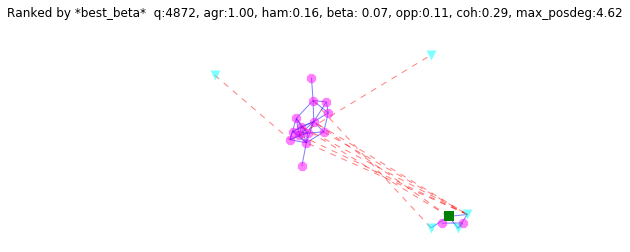

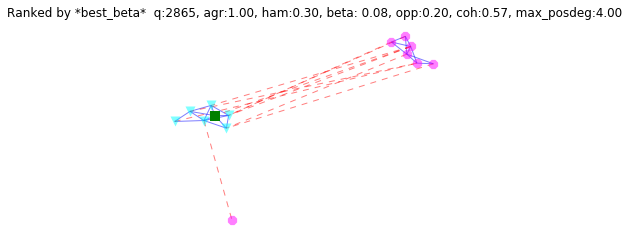

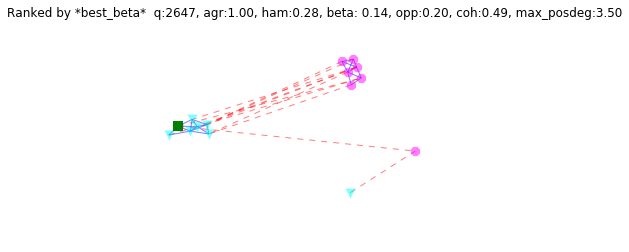

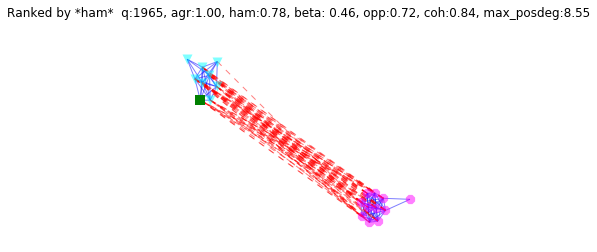

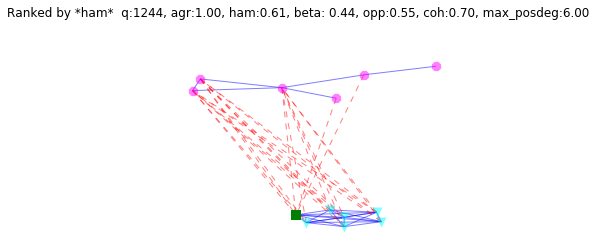

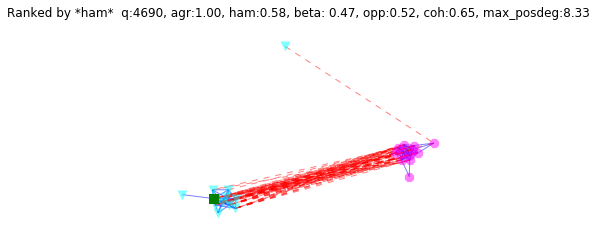

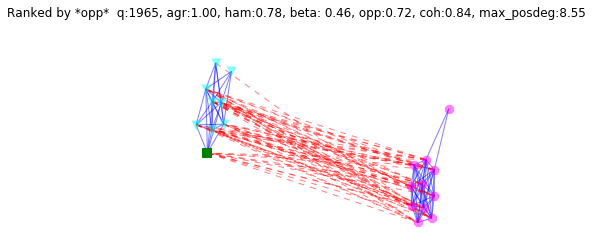

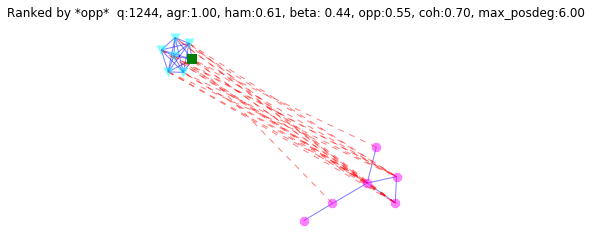

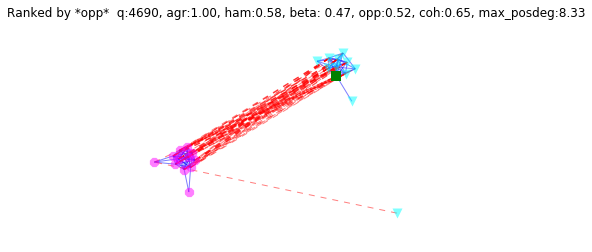

In [4]:
graph_showcase('word')

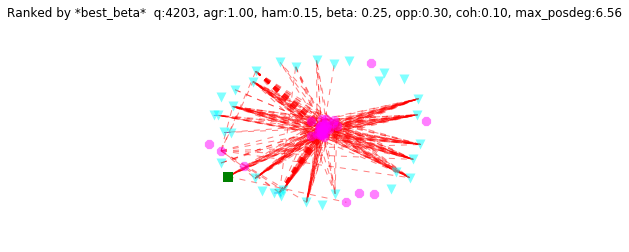

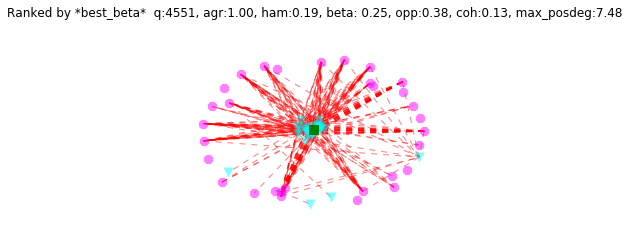

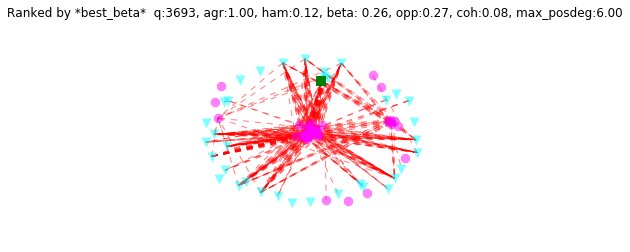

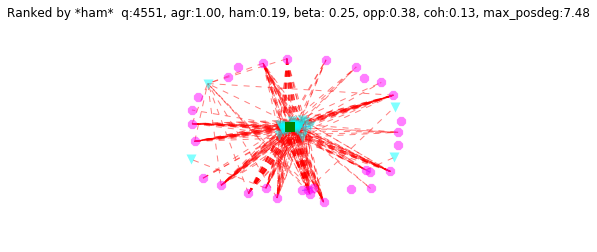

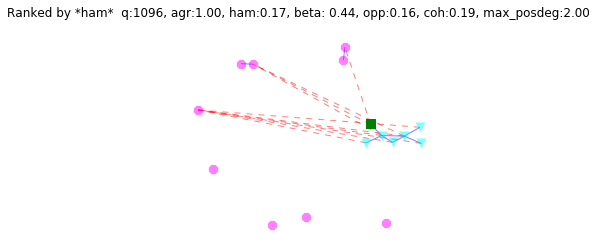

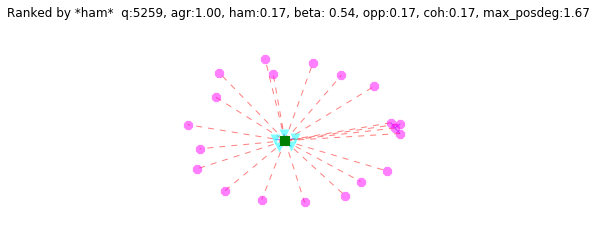

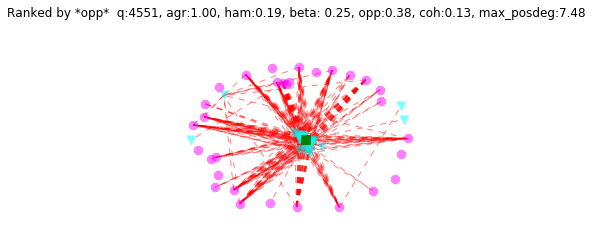

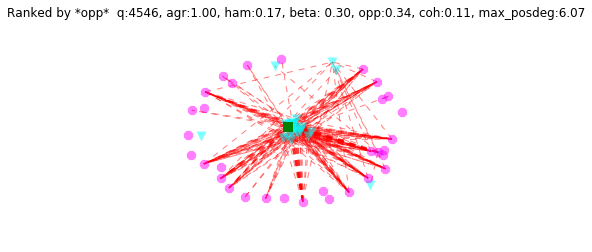

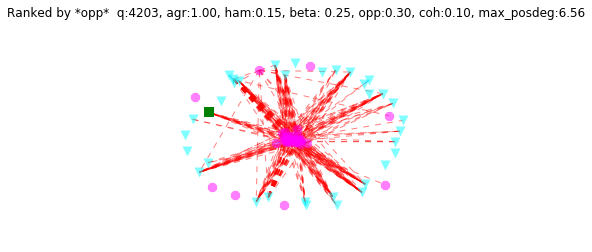

In [5]:
graph_showcase('bitcoin')

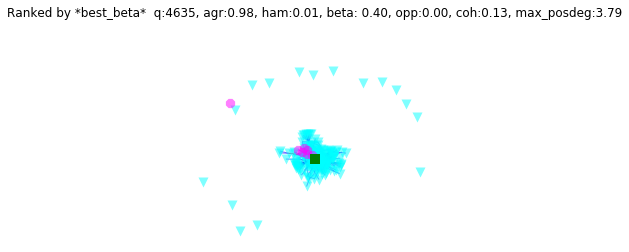

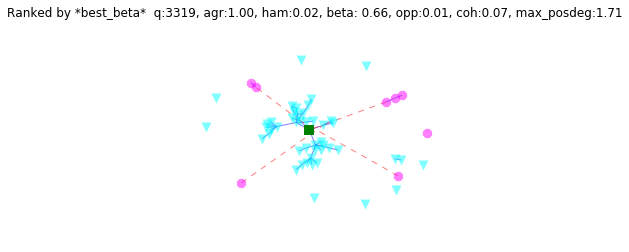

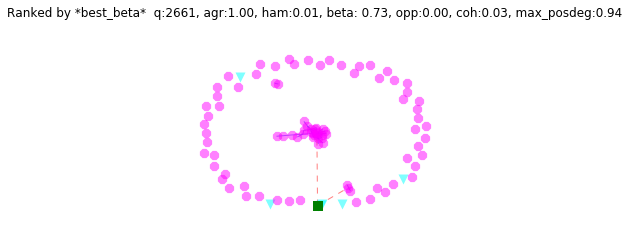

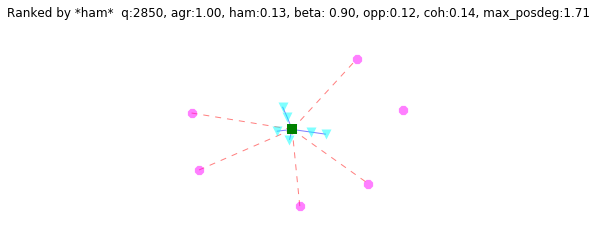

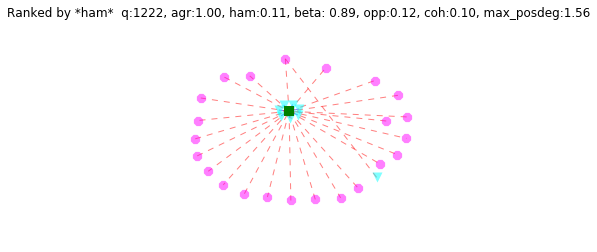

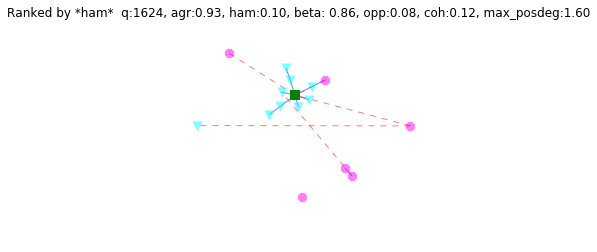

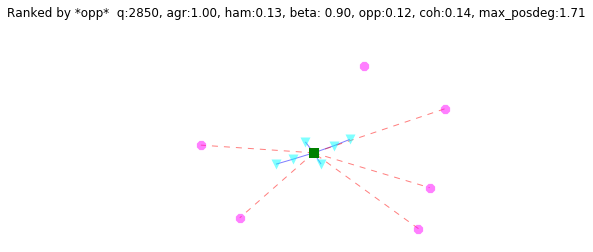

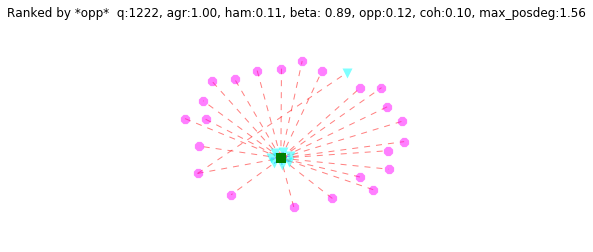

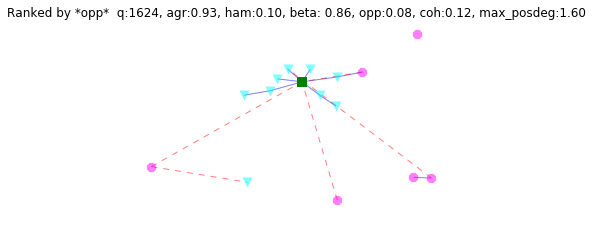

In [6]:
graph_showcase('ref')

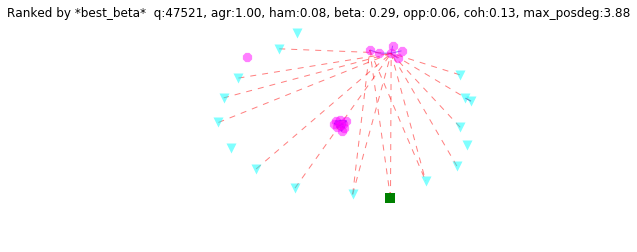

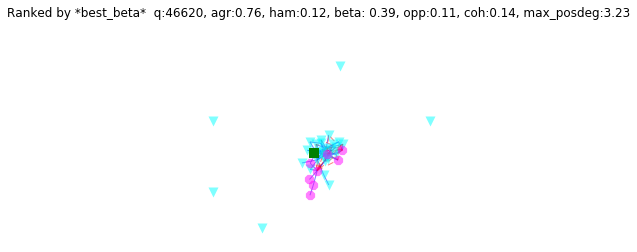

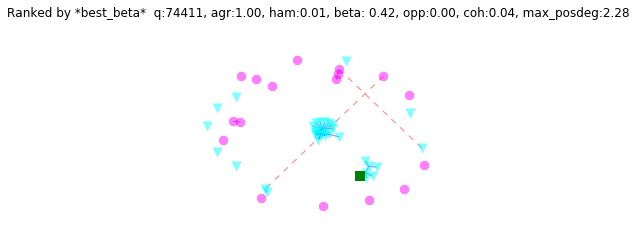

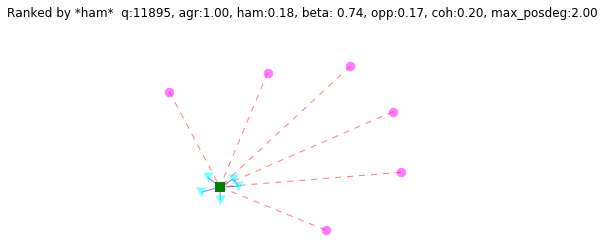

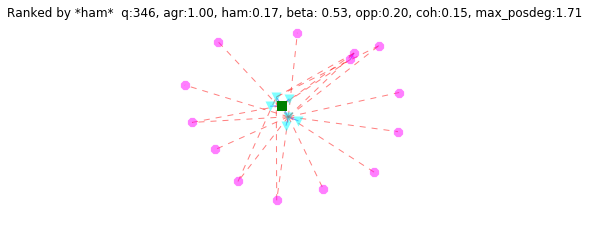

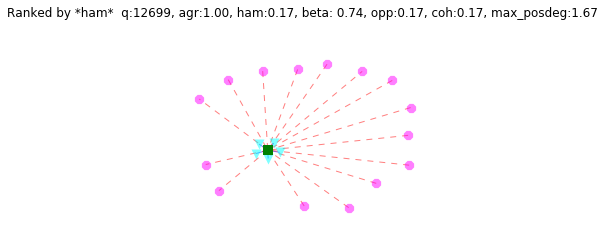

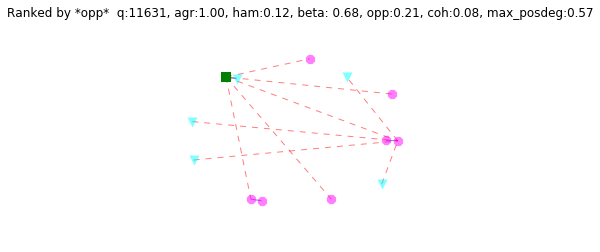

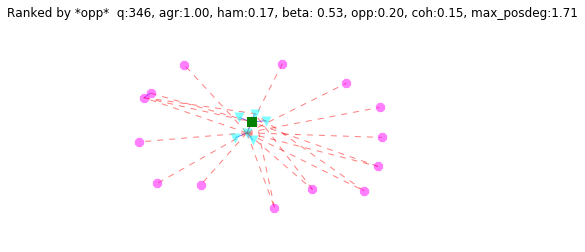

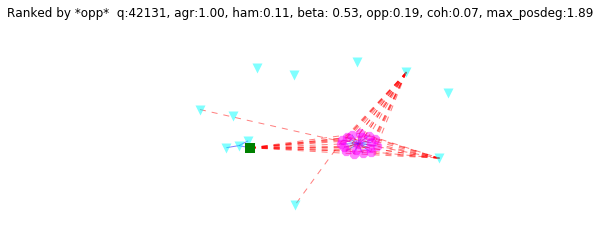

In [7]:
graph_showcase('slashdot')

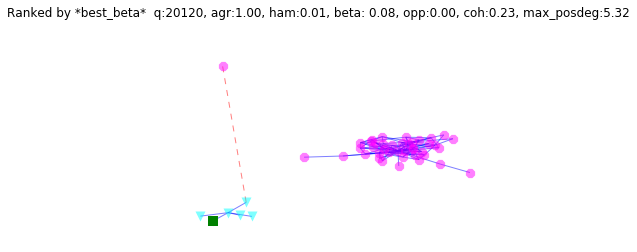

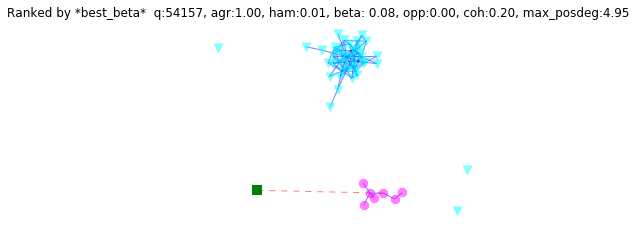

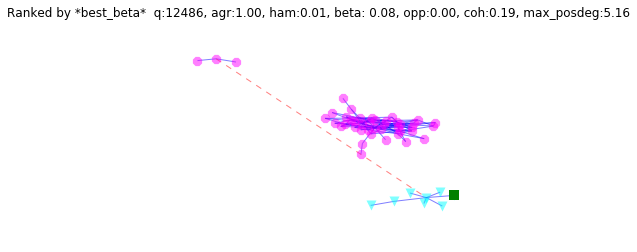

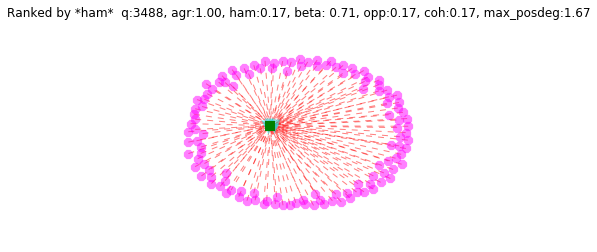

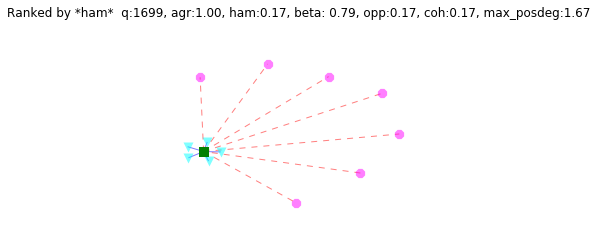

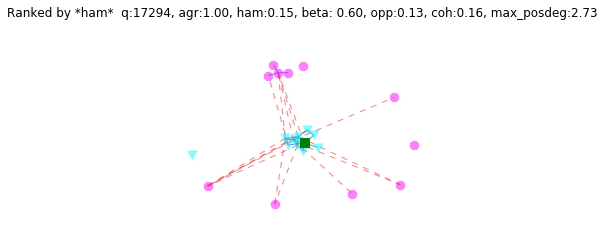

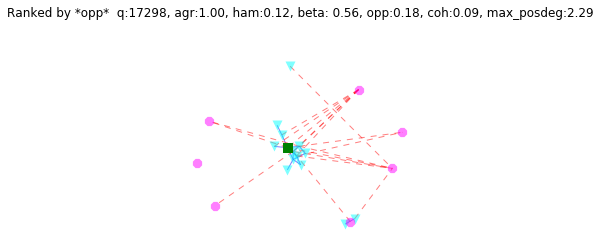

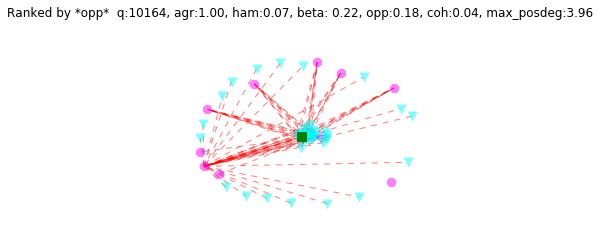

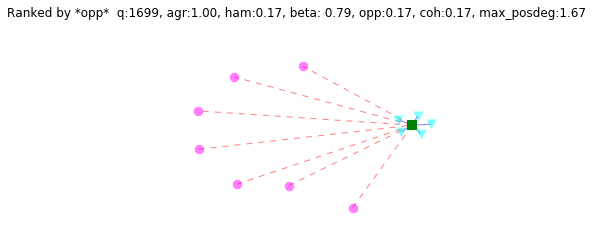

In [8]:
graph_showcase('epinions')

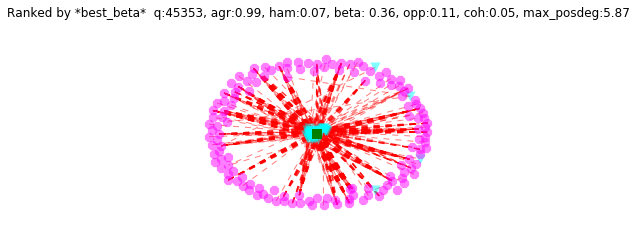

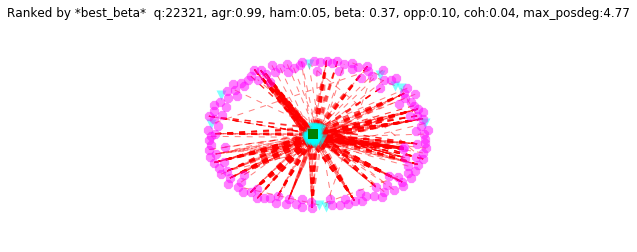

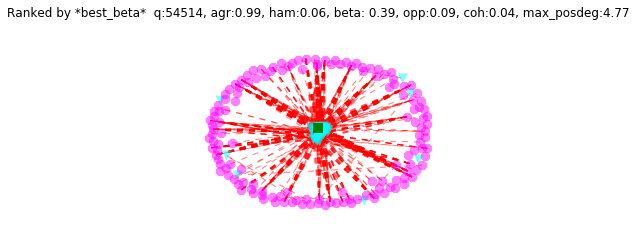

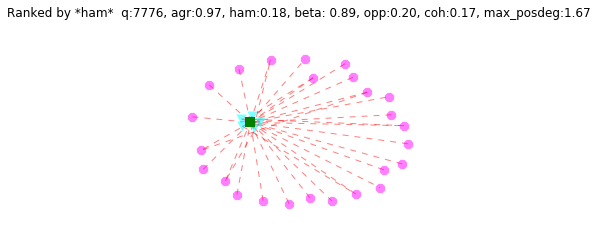

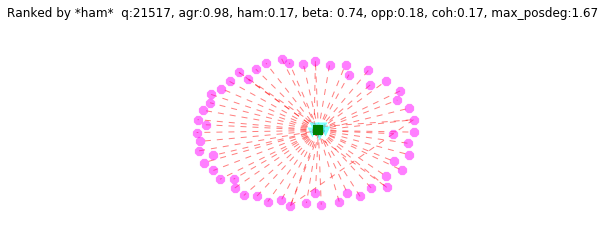

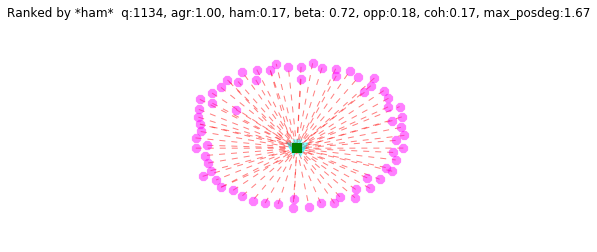

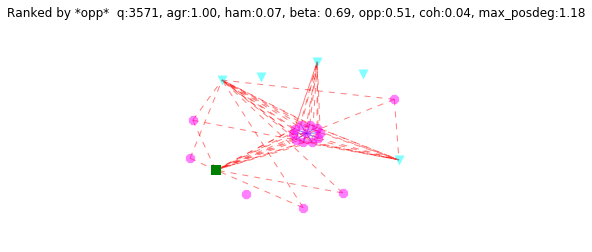

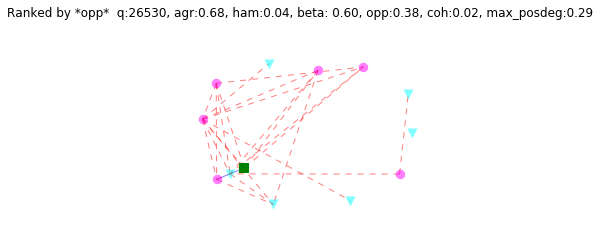

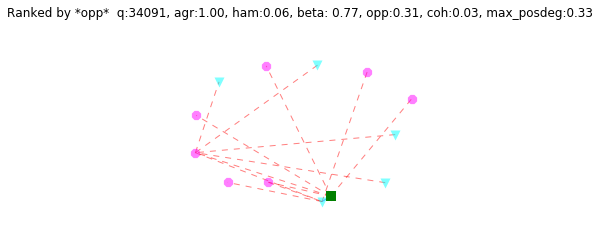

In [9]:
graph_showcase('wikiconflict')